# BinWaves example in Cantabria (Reconstruction)

### BinWaves Notebooks Overview

This Jupyter Notebook is the first of three in the **BinWaves** modeling workflow, following Cagigal et al., 2024 :

1. `BinWaves_Propagation.ipynb`  
2. `BinWaves_Reconstruction.ipynb`  
3. `BinWaves_Validation.ipynb`

---

#### Before You Start

Make sure you have:

- Installed the latest version of `bluemath-tk`:  
  ```bash
  pip install bluemath-tk

Before continuing, ensure you have **created and activated a Python environment**.

*** Other Required Packages ***
- `wavespectra` 
- `cartophy`
 
---

<details>
<summary><strong>📁 BinWaves_Propagation.ipynb</strong></summary>

This notebook constructs the **library of pre-run cases** for all **monochromatic wave systems**.

##### Requirements:

- A **bathymetry** file placed in the `common_inputs/` folder, in the correct format.

If you don't have a specific bathymetry file for your study area, you can:

- **Download GEBCO bathymetry data** (~400 m resolution):  [https://download.gebco.net/](https://download.gebco.net/)
- **NOTE**: You can use the `Bathymetry_GEBCO.ipynb` notebook to convert it to the required format.

</details>

---

<details open>
<summary><strong>📁 BinWaves_Reconstruction.ipynb</strong></summary>

This notebook reconstructs **wave conditions** using **offshore directional wave spectra**.

##### Requirements:

- Offshore wave spectrum data (e.g., **CAWCR** or **ERA5** datasets).
  - CAWCR spectra can be downloaded using a helper script (e.g., Javi's code?).

- **NOTE**: Optionally, apply **satellite corrections** to the hindcast spectrum before running BinWaves using the `CalVal` notebook, which handles the required format conversions.

</details>

---

<details>
<summary><strong>📁 BinWaves_Validation.ipynb</strong></summary>

This notebook performs **validation** using **wave buoy data**, if available.

##### Requirements:

- Wave buoy data in a format compatible with BinWaves (if available).
- Data can be freely downloaded from:  
  🌊 [https://www.ndbc.noaa.gov/](https://www.ndbc.noaa.gov/)

- **NOTE:** You can use the `NDBC_buoy_data.ipynb` notebook to:
  - Download the buoy data.
  - Convert it into the appropriate format for BinWaves.

</details>

In [2]:
import xarray as xr

# Load all the gridded kps and reproject
kp_coeffs = xr.open_dataset("outputs/kp_coefficients.nc")
kp_coeffs

<xarray.Dataset> Size: 365MB
Dimensions:   (case_num: 406, site: 151, freq: 31, dir: 24)
Coordinates:
  * case_num  (case_num) int64 3kB 0 1 2 3 4 5 6 ... 399 400 401 402 403 404 405
  * site      (site) int64 1kB 1 2 3 4 5 6 7 8 ... 145 146 147 148 149 150 151
  * freq      (freq) float64 248B 0.03 0.0329 0.0362 ... 0.4145 0.4552 0.5
  * dir       (dir) float64 192B 7.5 22.5 37.5 52.5 ... 307.5 322.5 337.5 352.5
    lat       float64 8B ...
    lon       float64 8B ...
    utm_x     (site) float64 1kB ...
    utm_y     (site) float64 1kB ...
Data variables:
    kps       (case_num, site, freq, dir) float64 365MB ...

In [5]:
import pandas as pd
from utils.operations import transform_ERA5_spectrum

model_parameters = pd.read_csv("CAN/swan_cases.csv").to_dict(orient="list")

# Load interest spectra
offshore_spectra, offshore_spectra_case = transform_ERA5_spectrum(
    era5_spectrum=xr.open_dataset("inputs/ERA5_offshore_spectra.nc"),
    subset_parameters=model_parameters,
    available_case_num=kp_coeffs.case_num.values,
   
)
offshore_spectra_case

<xarray.DataArray 'efth' (case_num: 406, time: 17520)> Size: 57MB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * case_num   (case_num) int64 3kB 0 1 2 3 4 5 6 ... 400 401 402 403 404 405
    longitude  float32 4B 356.1
    latitude   float32 4B 43.82
  * time       (time) datetime64[ns] 140kB 2009-01-01 ... 2010-12-31T23:00:00

In [6]:
from bluemath_tk.waves.binwaves import reconstruc_spectra

# Reconstruct spectra
time_to_reconstruct = "2010-02-20"
reconstructed_onshore_spectra = reconstruc_spectra(
    offshore_spectra=offshore_spectra_case.sel(time=time_to_reconstruct),
    kp_coeffs=kp_coeffs,
)
reconstructed_onshore_spectra

<xarray.Dataset> Size: 22MB
Dimensions:    (site: 151, freq: 31, dir: 24, time: 24)
Coordinates:
  * site       (site) int64 1kB 1 2 3 4 5 6 7 8 ... 145 146 147 148 149 150 151
  * freq       (freq) float64 248B 0.03 0.0329 0.0362 ... 0.4145 0.4552 0.5
  * dir        (dir) float64 192B 7.5 22.5 37.5 52.5 ... 307.5 322.5 337.5 352.5
    lat        float64 8B 0.0
    lon        float64 8B 0.0
    utm_x      (site) float64 1kB 4.252e+05 4.262e+05 ... 4.392e+05 4.288e+05
    utm_y      (site) float64 1kB 4.81e+06 4.81e+06 ... 4.819e+06 4.816e+06
    longitude  float32 4B 356.1
    latitude   float32 4B 43.82
  * time       (time) datetime64[ns] 192B 2010-02-20 ... 2010-02-20T23:00:00
Data variables:
    kps        (time, site, freq, dir) float64 22MB 0.0 0.0 0.0 ... 0.0 0.0 0.0

(<Figure size 1500x600 with 2 Axes>, <Axes: xlabel='cx', ylabel='cy'>)

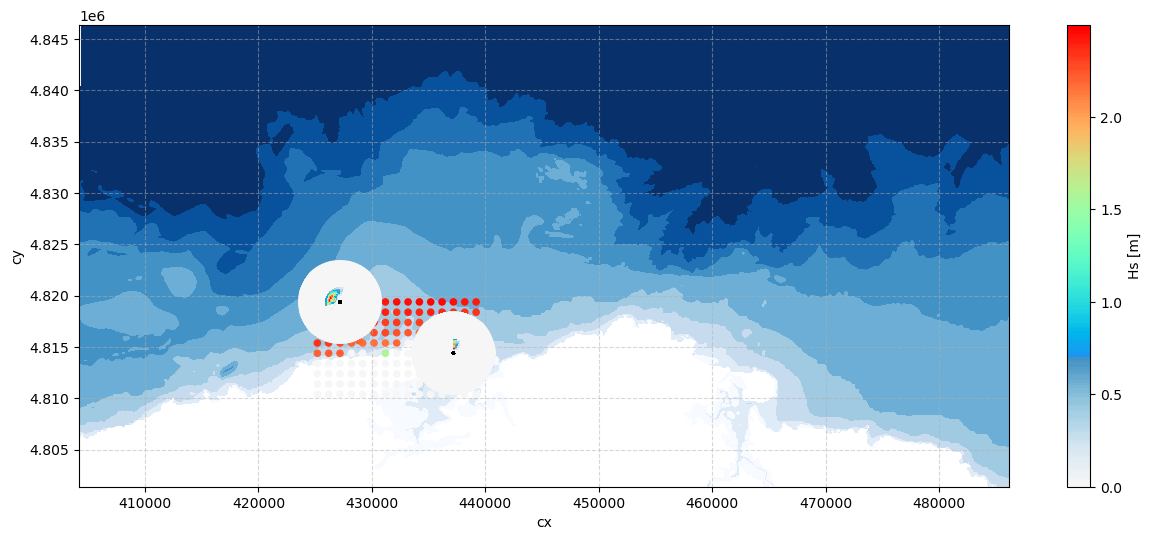

In [8]:
from utils.plotting import plot_spectrum_in_coastline

time_to_plot = "2010-02-20 12:00"

# Plot the spectrum along the coastline
bathy = xr.open_dataset("inputs/bathymetry_100m.nc").elevation.T
plot_spectrum_in_coastline(
    bathy=bathy,
    reconstructed_onshore_spectra=reconstructed_onshore_spectra.rename({"kps": "kp"}),
    reconstruction_kps=kp_coeffs,
    offshore_spectra=offshore_spectra,
    time_to_plot=time_to_plot,
    sites_for_spectrum=[137,72],
)